In [2]:
pip install tld


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412 kB 4.4 MB/s 


In [3]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from tld import get_tld, is_tld
from plotnine.data import mpg
from plotnine import ggplot, aes, geom_point, geom_bar, geom_boxplot, geom_hline, facet_grid, labs, geom_point, geom_col, stat_count, geom_histogram, stat_density, coord_flip
from plotnine import scale_x_continuous, scale_y_continuous, scale_colour_discrete, scale_x_reverse, scale_y_reverse, scale_color_manual, scale_color_brewer, scale_x_discrete, scale_fill_manual
from plotnine import theme_xkcd, theme_classic, theme_light, theme, element_blank
from plotnine import geom_text, position_stack
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus

In [4]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [5]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"estebanmayen","key":"77a752ce280a3a9ff128ef1fd8a84cfa"}'}

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download -d estebanmayen/bm-data

 41% 9.00M/22.0M [00:00<00:01, 8.75MB/s]
100% 22.0M/22.0M [00:01<00:00, 21.8MB/s]


In [8]:
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
!unzip bm-data.zip


Archive:  bm-data.zip
  inflating: Dataset_BM_1.csv        


# Analisis de Datos

In [10]:
data = pd.read_csv('/content/Dataset_BM_1.csv')
data.head()

,URL,TIPO
0,http://66.208.203.190:36841/malware.a,malware
1,http://58.255.129.35:53862/malware.a,malware
2,http://60.25.156.155:47183/malware.m,malware
3,http://192.72.17.236:35284/malware.a,malware
4,http://27.41.38.130:50541/malware.m,malware


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008870 entries, 0 to 1008869
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   URL     1008870 non-null  object
 1   TIPO    1008870 non-null  object
dtypes: object(2)
memory usage: 15.4+ MB


In [12]:
data.isnull().sum()

URL     0
TIPO    0
dtype: int64

In [13]:
count = data.TIPO.value_counts()
count

malware    545389
benign     463481
Name: TIPO, dtype: int64

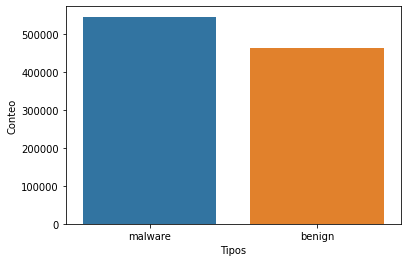

In [14]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Tipos')
plt.ylabel('Conteo');

In [15]:
data['URL'] = data['URL'].replace('www.', '', regex=True)
data

,URL,TIPO
0,http://66.208.203.190:36841/malware.a,malware
1,http://58.255.129.35:53862/malware.a,malware
2,http://60.25.156.155:47183/malware.m,malware
3,http://192.72.17.236:35284/malware.a,malware
4,http://27.41.38.130:50541/malware.m,malware
...,...,...
1008865,http://plastischechirurgie.net/gesicht/facelif...,malware
1008866,http://plastischechirurgie.net/haartransplanta...,malware
1008867,http://plastischechirurgie.net/korper/gynakoma...,malware
1008868,http://dl.get1993desk.com/n/50517366/RealPlaye...,malware


In [16]:
rem = {"Categoria": {"benign": 0, "malware": 1}}
data['Categoria'] = data['TIPO']
data = data.replace(rem)

In [17]:
data['URL_LEN'] = data['URL'].apply(lambda x: len(str(x)))

In [18]:
def process_tld(URL):
    try:
        res = get_tld(URL, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [19]:
data['DOMAIN'] = data['URL'].apply(lambda i: process_tld(i))

In [20]:
data.head(200)

,URL,TIPO,Categoria,URL_LEN,DOMAIN
0,http://66.208.203.190:36841/malware.a,malware,1,37,None
1,http://58.255.129.35:53862/malware.a,malware,1,36,None
2,http://60.25.156.155:47183/malware.m,malware,1,36,None
3,http://192.72.17.236:35284/malware.a,malware,1,36,None
4,http://27.41.38.130:50541/malware.m,malware,1,35,None
...,...,...,...,...,...
195,http://164.163.25.165:41491/bin.sh,malware,1,34,None
196,http://37.120.222.60/mysite/catimages/243.malware,malware,1,49,None
197,http://37.120.222.60/mysite/catimages/244.malware,malware,1,49,None
198,http://37.120.222.60/mysite/catimages/242.malware,malware,1,49,None


In [21]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['URL'].apply(lambda i: i.count(a))

In [22]:
data.head()

,URL,TIPO,Categoria,URL_LEN,DOMAIN,@,?,-,=,.,#,%,+,$,!,*,",",//
0,http://66.208.203.190:36841/malware.a,malware,1,37,None,0,0,0,0,4,0,0,0,0,0,0,0,1
1,http://58.255.129.35:53862/malware.a,malware,1,36,None,0,0,0,0,4,0,0,0,0,0,0,0,1
2,http://60.25.156.155:47183/malware.m,malware,1,36,None,0,0,0,0,4,0,0,0,0,0,0,0,1
3,http://192.72.17.236:35284/malware.a,malware,1,36,None,0,0,0,0,4,0,0,0,0,0,0,0,1
4,http://27.41.38.130:50541/malware.m,malware,1,35,None,0,0,0,0,4,0,0,0,0,0,0,0,1


In [23]:
def abnormal_url(URL):
    hostname = urlparse(URL).hostname
    hostname = str(hostname)
    match = re.search(hostname, URL)
    if match:
        #hay una relacion
        return 1
    else:
        #no se encontre relacion
        return 0

In [24]:
data['abnormal_url'] = data['URL'].apply(lambda i: abnormal_url(i))

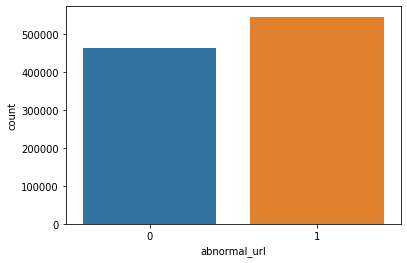

In [25]:
sns.countplot(x='abnormal_url', data=data);

In [26]:
def httpSecure(URL):
    htp = urlparse(URL).scheme
    match = str(htp)
    if match=='https':
        #hay una relacion
        return 1
    else:
        # no hay ninguna relacion
        return 0

In [27]:
data['https'] = data['URL'].apply(lambda i: httpSecure(i))

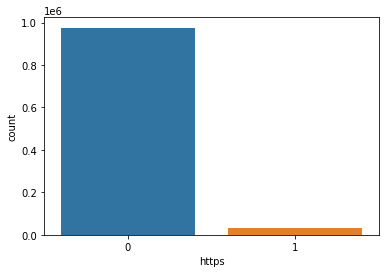

In [28]:
sns.countplot(x='https', data=data);

In [29]:
def digit_count(URL):
    digits = 0
    for i in URL:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [30]:
data['digits'] = data['URL'].apply(lambda i: digit_count(i))

In [31]:
def letter_count(URL):
    letters = 0
    for i in URL:
        if i.isalpha():
            letters = letters + 1
    return letters

In [32]:
data['letters']= data['URL'].apply(lambda i: letter_count(i))

In [33]:
def having_ip_address(URL):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  #identificador de IPV4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # identificador de IPv4 con puerto
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # identificador de IPv4 en hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', URL)  # identificador de Ipv6
    if match:
        return 1
    else:
        return 0

In [34]:
data['having_ip_address'] = data['URL'].apply(lambda i: having_ip_address(i))

In [35]:
data['having_ip_address'].value_counts()

0    832348
1    176522
Name: having_ip_address, dtype: int64

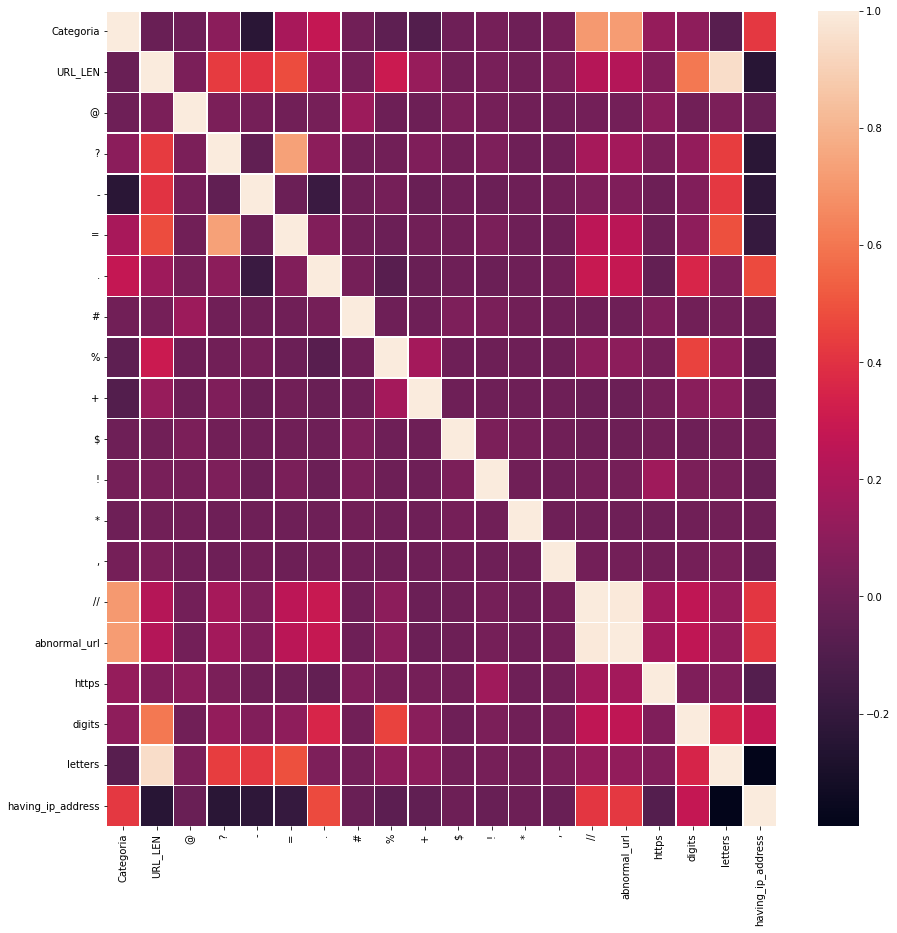

In [36]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), linewidths=.5)

In [37]:
feature_column=['URL','TIPO','Categoria','DOMAIN']
X = data.drop(['URL','TIPO','Categoria','DOMAIN'],axis=1)
y = data['Categoria']

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008870 entries, 0 to 1008869
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   URL                1008870 non-null  object
 1   TIPO               1008870 non-null  object
 2   Categoria          1008870 non-null  int64 
 3   URL_LEN            1008870 non-null  int64 
 4   DOMAIN             832679 non-null   object
 5   @                  1008870 non-null  int64 
 6   ?                  1008870 non-null  int64 
 7   -                  1008870 non-null  int64 
 8   =                  1008870 non-null  int64 
 9   .                  1008870 non-null  int64 
 10  #                  1008870 non-null  int64 
 11  %                  1008870 non-null  int64 
 12  +                  1008870 non-null  int64 
 13  $                  1008870 non-null  int64 
 14  !                  1008870 non-null  int64 
 15  *                  1008870 non-null  int64 
 16  

In [39]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [40]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

In [41]:
dtree = DecisionTreeClassifier()
model = [DecisionTreeClassifier]
dtree.fit(X_train, y_train)
y_predict = dtree.predict(X_test)
cm = confusion_matrix(y_test, y_predict)
cm

    

array([[ 90549,   2235],
       [  7432, 101558]])

Text(0.5, 15.0, 'Categoría predicha')

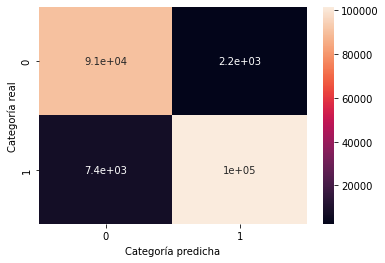

In [42]:
url = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(url))
plt.xticks(tick_marks, url)
plt.yticks(tick_marks, url)
sns.heatmap(pd.DataFrame(cm), annot = True)
plt.ylabel("Categoría real")
plt.xlabel("Categoría predicha")

In [43]:
print("Accuracy:", accuracy_score(y_test, y_predict))
print("Precisión:",precision_score(y_test, y_predict))
print("Recall:", recall_score(y_test, y_predict))
print("F1-score:", f1_score(y_test, y_predict))

Accuracy: 0.9520899620367341
Precisión: 0.9784667559469329
Recall: 0.9318102578218185
F1-score: 0.9545687390440026
